# 逻辑回归

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/logo.png" width=150>

在上一节中，我们看到线性回归可以很好的拟合出一条线后者一个超平面来做出对连续变量的预测。但是在分类问题中我们希望的输出是类别的概率，线性回归就不能做的很好了。





# 概述

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/logistic.jpg" width=270>

$ \hat{y} = \frac{1}{1 + e^{-XW}} $ 

*where*:
* $\hat{y}$ = 预测值 | $\in \mathbb{R}^{NX1}$ ($N$ 是样本的个数)
* $X$ = 输入 | $\in \mathbb{R}^{NXD}$ ($D$ 是特征的个数)
* $W$ = 权重 | $\in \mathbb{R}^{DX1}$ 

这个是二项式逻辑回归。主要思想是用线性回归的输出值($z=XW$)经过一个sigmoid函数($\frac{1}{1+e^{-z}}$)来映射到(0, 1)之间。

当我们有多于两个分类类别，我们就需要使用多项式逻辑回归(softmax分类器)。softmax分类器将会用线性方程($z=XW$)并且归一化它，来产生对应的类别y的概率。

$ \hat{y} = \frac{e^{XW_y}}{\sum e^{XW}} $ 

*where*:
* $\hat{y}$ = 预测值 | $\in \mathbb{R}^{NX1}$ ($N$ 是样本的个数)
* $X$ = 输入 | $\in \mathbb{R}^{NXD}$ ($D$ 是特征的个数)
* $W$ = 权重 | $\in \mathbb{R}^{DXC}$ ($C$ 是类别的个数)


* **目标:**  通过输入值$X$来预测$y$的类别概率。softmax分类器将根据归一化线性输出来计算类别概率。 
* **优点:**
  * 可以预测与输入对应的类别概率。
* **缺点:**
  * 因为使用的损失函数是要最小化交叉熵损失，所以对离群点很敏感。(支持向量机([SVMs](https://towardsdatascience.com/support-vector-machine-vs-logistic-regression-94cc2975433f)) 是对处理离群点一个很好的选择).
* **其他:** Softmax分类器在神经网络结构中广泛用于最后一层，因为它会计算出类别的概率。

# 训练

*步骤*:

1. 随机初始化模型权重$W$.
2. 将输入值 $X$ 传入模型并且得到logits ($z=XW$). 在logits上使用softmax操作得到独热编码后的类别概率$\hat{y}$。 比如, 如果有三个类别, 预测出的类别概率可能为[0.3, 0.3, 0.4]. 
3. 使用损失函数将预测值$\hat{y}$ (例如[0.3, 0.3, 0.4]])和真实值$y$(例如属于第二个类别应该写作[0, 0, 1])做对比，并且计算出损失值$J$。一个很常用的逻辑回归损失函数是交叉熵函数。 
  * $J(\theta) = - \sum_i y_i ln (\hat{y_i}) =  - \sum_i y_i ln (\frac{e^{X_iW_y}}{\sum e^{X_iW}}) $
   * $y$ = [0, 0, 1]
  * $\hat{y}$ = [0.3, 0.3, 0.4]]
  * $J(\theta) = - \sum_i y_i ln (\hat{y_i}) =  - \sum_i y_i ln (\frac{e^{X_iW_y}}{\sum e^{X_iW}}) = - \sum_i [0 * ln(0.3) + 0 * ln(0.3) + 1 * ln(0.4)] = -ln(0.4) $
  * 简化我们的交叉熵函数: $J(\theta) = - ln(\hat{y_i})$ (负的最大似然).
  * $J(\theta) = - ln(\hat{y_i}) = - ln (\frac{e^{X_iW_y}}{\sum_i e^{X_iW}}) $
4. 根据模型权重计算损失梯度$J(\theta)$。让我们假设类别的分类是互斥的(一种输入仅仅对应一个输出类别).
 * $\frac{\partial{J}}{\partial{W_j}} = \frac{\partial{J}}{\partial{y}}\frac{\partial{y}}{\partial{W_j}} = - \frac{1}{y}\frac{\partial{y}}{\partial{W_j}} = - \frac{1}{\frac{e^{W_yX}}{\sum e^{XW}}}\frac{\sum e^{XW}e^{W_yX}0 - e^{W_yX}e^{W_jX}X}{(\sum e^{XW})^2} = \frac{Xe^{W_j}X}{\sum e^{XW}} = XP$
  * $\frac{\partial{J}}{\partial{W_y}} = \frac{\partial{J}}{\partial{y}}\frac{\partial{y}}{\partial{W_y}} = - \frac{1}{y}\frac{\partial{y}}{\partial{W_y}} = - \frac{1}{\frac{e^{W_yX}}{\sum e^{XW}}}\frac{\sum e^{XW}e^{W_yX}X - e^{W_yX}e^{W_yX}X}{(\sum e^{XW})^2} = \frac{1}{P}(XP - XP^2) = X(P-1)$
5. 使用梯度下降法来对权重做反向传播以更新模型权重。更新后的权重将会使不正确的类别(j)概率大大降低，从而升高正确的类别(y)概率。
  * $W_i = W_i - \alpha\frac{\partial{J}}{\partial{W_i}}$
6. 重复2 - 4步直到模型表现最好（也可以说直到损失收敛）。

# 数据

我们来加载在第三节课中用到的titanic数据集

In [1]:
from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib

In [3]:
# 参数
args = Namespace(
    seed=1234,
    data_file="titanic.csv",
    train_size=0.75,
    test_size=0.25,
    num_epochs=100,
)

# 设置随即种子来保证实验结果的可重复性。
np.random.seed(args.seed)

In [4]:
# 从GitHub上加载数据到notebook本地驱动
url = "https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/data/titanic.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(args.data_file, 'wb') as f:
    f.write(html)

In [5]:
# 把CSV文件内容读到DataFrame中
df = pd.read_csv(args.data_file, header=0)
df.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,survived
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,1
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,1
2,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,0
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,0
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,0


# Scikit-learn实现

**注意**: Scikit-learn中`LogisticRegression`类使用的是坐标下降法（coordinate descent）来做的拟合。然而，我们会使用Scikit-learn中的`SGDClassifier`类来做随机梯度下降。我们使用这个优化方法是因为在未来的几节课程中我们也会使用到它。

In [6]:
# 调包
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [7]:
# 预处理
def preprocess(df):
  
    # 删除掉含有空值的行
    df = df.dropna()

    # 删除基于文本的特征 (我们以后的课程将会学习怎么使用它们)
    features_to_drop = ["name", "cabin", "ticket"]
    df = df.drop(features_to_drop, axis=1)

    # pclass, sex, 和 embarked 是类别变量
    categorical_features = ["pclass","embarked","sex"]
    df = pd.get_dummies(df, columns=categorical_features)

    return df

In [8]:
# 数据预处理
df = preprocess(df)
df.head()

,age,sibsp,parch,fare,survived,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,embarked_S,sex_female,sex_male
0,29.0000,0,0,211.3375,1,1,0,0,0,0,1,1,0
1,0.9167,1,2,151.5500,1,1,0,0,0,0,1,0,1
2,2.0000,1,2,151.5500,0,1,0,0,0,0,1,1,0
3,30.0000,1,2,151.5500,0,1,0,0,0,0,1,0,1
4,25.0000,1,2,151.5500,0,1,0,0,0,0,1,1,0


In [9]:
# 划分数据到训练集和测试集
mask = np.random.rand(len(df)) < args.train_size
train_df = df[mask]
test_df = df[~mask]
print ("Train size: {0}, test size: {1}".format(len(train_df), len(test_df)))

Train size: 199, test size: 71


**注意**: 如果你有类似标准化的预处理步骤，你需要在划分完训练集和测试集之后再使用它们。这是因为我们不可能从测试集中学到任何有用的信息。

In [10]:
# 分离 X 和 y
X_train = train_df.drop(["survived"], axis=1)
y_train = train_df["survived"]
X_test = test_df.drop(["survived"], axis=1)
y_test = test_df["survived"]

In [11]:
# 标准化训练数据 (mean=0, std=1)
X_scaler = StandardScaler().fit(X_train)

# 标准化训练和测试数据  (不要标准化标签分类y)
standardized_X_train = X_scaler.transform(X_train)
standardized_X_test = X_scaler.transform(X_test)

# 检查
print ("mean:", np.mean(standardized_X_train, axis=0)) # mean 应该为 ~0
print ("std:", np.std(standardized_X_train, axis=0))   # std 应该为 1

mean: [-1.78528326e-17  7.14113302e-17 -5.80217058e-17 -5.35584977e-17
  3.57056651e-17 -8.92641628e-17  3.57056651e-17 -3.79372692e-17
  0.00000000e+00  3.79372692e-17  1.04885391e-16 -6.69481221e-17]
std: [1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]


In [12]:
# 初始化模型
log_reg = SGDClassifier(loss="log", penalty="none", max_iter=args.num_epochs, 
                        random_state=args.seed)

In [13]:
# 训练
log_reg.fit(X=standardized_X_train, y=y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=100, n_iter=None,
       n_jobs=1, penalty='none', power_t=0.5, random_state=1234,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [14]:
# 概率
pred_test = log_reg.predict_proba(standardized_X_test)
print (pred_test[:5])

[[0.60319594 0.39680406]
 [0.00374908 0.99625092]
 [0.81886302 0.18113698]
 [0.01082253 0.98917747]
 [0.93508814 0.06491186]]


In [15]:
# 预测 (未标准化)
pred_train = log_reg.predict(standardized_X_train) 
pred_test = log_reg.predict(standardized_X_test)
print (pred_test)

[0 1 0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0
 1 0 0 1 1 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]


# 评估指标

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
# 正确率
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print ("train acc: {0:.2f}, test acc: {1:.2f}".format(train_acc, test_acc))

train acc: 0.77, test acc: 0.82


到目前为止我们用的是正确率作为我们的评价指标来评定模型的好坏程度。但是我们还有很多的评价指标来对模型进行评价。

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/metrics.jpg" width=400>

评价指标的选择真的要看应用的情景。
positive - true, 1, tumor, issue, 等等, negative - false, 0, not tumor, not issue, 等等。

$\text{accuracy}（正确率） = \frac{TP+TN}{TP+TN+FP+FN}$ 

$\text{recall}（召回率）= \frac{TP}{TP+FN}$ → (有多个正例被我分为正例)

$\text{precision} （精确率）= \frac{TP}{TP+FP}$ → (在所有我预测为正例的样本下，有多少是对的)

$F_1 = 2 * \frac{\text{precision }  *  \text{ recall}}{\text{precision } + \text{ recall}}$

where: 
* TP: 将正类预测为正类数
* TN: 将负类预测为负类数
* FP: 将负类预测为正类数
* FN: 将正类预测为负类数

In [18]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes):
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

             precision    recall  f1-score   support

          0       0.74      0.91      0.82        32
          1       0.91      0.74      0.82        39

avg / total       0.83      0.82      0.82        71



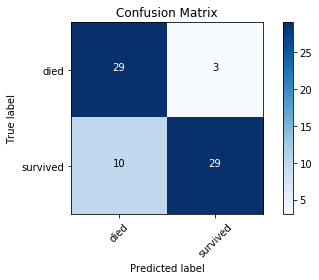

In [20]:
# 混淆矩阵
cm = confusion_matrix(y_test, pred_test)
plot_confusion_matrix(cm=cm, classes=["died", "survived"])
print (classification_report(y_test, pred_test))

当我们有大于两个标签（二分类）的时候，我们可以选择在微观/宏观层面计算评估指标（每个clas标签）、权重等。 更详细内容可以参考[offical docs](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html).

# 推论

现在我们来看看你是否会在Titanic中存活下来

In [21]:
# 输入你自己的信息
X_infer = pd.DataFrame([{"name": "Goku Mohandas", "cabin": "E", "ticket": "E44", 
                         "pclass": 1, "age": 24, "sibsp": 1, "parch": 2, 
                         "fare": 100, "embarked": "C", "sex": "male"}])
X_infer.head()

,age,cabin,embarked,fare,name,parch,pclass,sex,sibsp,ticket
0,24,E,C,100,Goku Mohandas,2,1,male,1,E44


In [22]:
# 进行预处理
X_infer = preprocess(X_infer)
X_infer.head()

,age,fare,parch,sibsp,pclass_1,embarked_C,sex_male
0,24,100,2,1,1,1,1


In [23]:
# 添加缺失列向量
missing_features = set(X_test.columns) - set(X_infer.columns)
for feature in missing_features:
    X_infer[feature] = 0

# 重整title
X_infer = X_infer[X_train.columns]
X_infer.head()

,age,sibsp,parch,fare,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,embarked_S,sex_female,sex_male
0,24,1,2,100,1,0,0,1,0,0,0,1


In [24]:
# 标准化
standardized_X_infer = X_scaler.transform(X_infer)

In [25]:
# 预测
y_infer = log_reg.predict_proba(standardized_X_infer)
classes = {0: "died", 1: "survived"}
_class = np.argmax(y_infer)
print ("Looks like I would've {0} with about {1:.0f}% probability on the Titanic expedition!".format(
    classes[_class], y_infer[0][_class]*100.0))

Looks like I would've survived with about 57% probability on the Titanic expedition!


# 可解释性

哪些特征是最有影响力的？

In [26]:
# 未标准化系数
coef = log_reg.coef_ / X_scaler.scale_
intercept = log_reg.intercept_ - np.sum((coef * X_scaler.mean_))
print (coef)
print (intercept)

[[-0.02155712  0.39758992  0.78341184 -0.0070509  -2.71953415  2.01530102
   3.50708962  0.11008796  0.         -0.11008796  2.94675085 -2.94675085]]
[5.10843738]


正系数表示与阳性类的相关性（1 = 存活），负系数表示与阴性类的相关性（0 = 死亡）。

In [27]:
indices = np.argsort(coef)
features = list(X_train.columns)
print ("Features correlated with death:", [features[i] for i in indices[0][:3]])
print ("Features correlated with survival:", [features[i] for i in indices[0][-3:]])

Features correlated with death: ['sex_male', 'pclass_1', 'embarked_S']
Features correlated with survival: ['pclass_2', 'sex_female', 'pclass_3']


### 非标准化系数的证明:



注意我们的X和y都已经标准化了。

$\mathbb{E}[y] = W_0 + \sum_{j=1}^{k}W_jz_j$

$z_j = \frac{x_j - \bar{x}_j}{\sigma_j}$

$ \hat{y} = \hat{W_0} + \sum_{j=1}^{k}\hat{W_j}z_j $

$\hat{y} = \hat{W_0} + \sum_{j=1}^{k} \hat{W}_j (\frac{x_j - \bar{x}_j}{\sigma_j}) $

$\hat{y} = (\hat{W_0} - \sum_{j=1}^{k} \hat{W}_j\frac{\bar{x}_j}{\sigma_j}) +  \sum_{j=1}^{k} (\frac{\hat{w}_j}{\sigma_j})x_j$

# K折交叉验证

交叉验证是一个重采样的模型评估方法。与其我们在一开始就仅仅划分一次训练集和验证集，我们用交叉验证来划分k(通常 k=5 或者 10)次不同的训练集和验证集。

步骤:
1.   随机打乱训练数据集*train*。
2.   将数据集分割成不同的k个片段。
3.   在k次的每次循环中选择一个片段来当作验证集，其余的所有片段当成训练集。
4.   重复这个过程使每个片段都有可能成为训练集或者测试集的一部分。
5.   随机初始化权重来训练模型。
6.   在k个循环中每次都要重新初始化模型，但是权重要保持相同的随机初始化，然后再在验证集中进行验证。



In [29]:
from sklearn.model_selection import cross_val_score

In [30]:
#  K折交叉验证
log_reg = SGDClassifier(loss="log", penalty="none", max_iter=args.num_epochs)
scores = cross_val_score(log_reg, standardized_X_train, y_train, cv=10, scoring="accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.66666667 0.7        0.7        0.4        0.7        0.7
 0.85       0.7        0.68421053 0.78947368]
Mean: 0.6890350877192982
Standard Deviation: 0.10984701440790533


# TODO

- interaction terms
- interpreting odds ratio
- simple example with coordinate descent method (sklearn.linear_model.LogisticRegression)